In [1]:
using DataFrames, LogTopReg, Distributions

In [24]:
K = 3;
σ_μ = 0.0;
σ_A = sqrt([0.0,0.8,0.2]);
σ = sqrt([0.0,0.2,0.8]);

n = 500;
nd = repeat([50],inner=[n]);
A = rand(InverseWishart(n+1,eye(n)));
A = A./(sqrt(diag(A))*sqrt(diag(A))');
UA = chol(A);
y = Vector{Array{Int64,2}}(n);
μ = randn(K)*σ_μ;
g = randn(K,n)*UA;

p = 2;
X = randn(p,n);
β = zeros(K,p);

In [25]:
θ = linspace(0.1,K*2,K).^2;
η = Array{Float64}(K,n);
nk = Array{Int64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ + σ_A.*g[:,i];
    nk[:,i] = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = hcat(map(j -> hcat(rand(Poisson(θ[j]),nk[j,i]),rand(Poisson(θ[K:-1:1][j]),nk[j,i]))', 1:K)...);
end

In [33]:
pss0 = VectorPosterior(PoissonPosterior(0.01,0.01),2);
niter = 2000;
thin = 2;
ns = div(niter,thin);
hyper = hyperparameter(τ0_u = 0.01,ν0_u=0.33,ν0_σ2η=0.01,σ0_σ2η = 0.01,τ0_τ = 0.01,ν0_τ = 0.01,τ_β = 1.0);

In [34]:
@time fit = topiclmm(y,X,convert(Array{Float64,2},UA),pss0,K,hyper,iter=niter,thin=thin);

616.650440 seconds (1.93 G allocations: 366.810 GB, 35.95% gc time)


In [15]:
using Gadfly

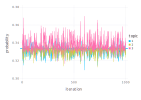

In [35]:
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(layer(mudat,x="iteration",y="probability",color="topic",Geom.line),
layer(yintercept=softmax(μ),Geom.hline))

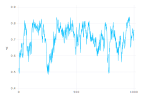

In [36]:
guh = fit[:τ_u][1,:].*fit[:σ2][1,:] + fit[:τ_u][2,:].*fit[:σ2][2,:];
plot(y=guh./(guh + fit[:σ2][1,:]+fit[:σ2][2,:]),Geom.line)

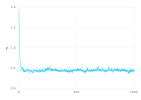

In [39]:
plot(y=sqrt(fit[:σ2][1,:]+fit[:σ2][2,:]),yintercept=[sqrt(σ[1]^2+σ[2]^2)],Geom.line,Geom.hline)

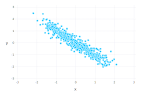

In [40]:
plot(x=mean((fit[:η][1,:,:]-fit[:η][2,:,:])[:,div(ns,2):ns],2),y=η[1,:]-η[2,:])

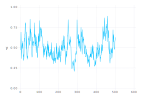

In [41]:
plot(y=var(fit[:u][:,1,:] .- fit[:u][:,2,:],1)[div(ns,2):ns],Geom.line)

In [43]:
plot(x=mean( (fit[:η][1,:,:]-fit[:η][2,:,:])[:,div(ns,2):ns] - UA'*(fit[:u][:,1,:] - fit[:u][:,2,:])[:,div(ns,2):ns],2),
y= (η[1,:]-η[2,:]) - σ_A.*(g[1,:]-g[2,:]))

LoadError: DimensionMismatch("arrays could not be broadcast to a common size")

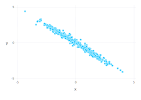

In [21]:
plot(x=mean(UA'*(fit[:u][:,1,:] - fit[:u][:,2,:])[:,div(ns,2):ns],2),
y= σ_A.*(g[1,:]-g[2,:]))